# CNN Advanced (EMNIST dataset)

In [1]:
# Run the comment below only when using Google Colab
# !pip install torch torchvision

Google Colab에서 실행할 경우 위 주석을 해제하고 실행하면 됨. Colab에는 pytorch가 설치되어있지 않으므로 설치 필요.

In [1]:
import torch
import torchvision
import torch.nn as nn

In [2]:
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset

In [3]:
from torchvision import transforms

In [4]:
import urllib
import numpy as np
import datetime
import os, sys
from PIL import Image

In [5]:
from matplotlib.pyplot import imshow, imsave
%matplotlib inline

In [6]:
MODEL_NAME = 'CNN'
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
class EMNIST(Dataset):
    '''
    EMNIST Dataset (split: letters)
    Reference:
        Dataset: https://www.kaggle.com/crawford/emnist
        Paper: https://arxiv.org/abs/1702.05373v1
    '''
    url = {
        'train': 'https://www.dropbox.com/s/pnfxiohzpq75i6a/emnist-train.npy?dl=1',
        'test': 'https://www.dropbox.com/s/2sl1kzcemnh2qlj/emnist-test.npy?dl=1',
    }
    
    def __init__(self, data_path, transform, download=True, train=True):
        '''
        Args:
            data_path (str): path to dataset
        '''
        self.data_path = data_path
        self.transform = transform
        self.mode = 'train' if train else 'test'
        if download:
            fpath = self._download(self.url[self.mode], data_path)
        else:
            fpath = os.path.join(data_path, 'emnist-{}.npy'.format(self.mode))
        _file = np.load(fpath)
        self.images = _file[:, 1:].reshape([len(_file), 28, 28])
        self.labels = torch.tensor(_file[:, 0]-1, dtype=torch.long)
        
    def __getitem__(self, idx):
        imgs = self.transform(Image.fromarray(self.images[idx]))
        return imgs, self.labels[idx]

    def __len__(self):
        return len(self.labels)
    
    def _download(self, url, data_path):
        data = urllib.request.urlopen(url)
        filename = url.rpartition('/')[-1][:-5]
        if not os.path.exists(data_path):
            os.makedirs(data_path)
        file_path = os.path.join(data_path, filename)
        with open(file_path, 'wb') as f:
            f.write(data.read())
        print('Downloaded: ', file_path)
        return file_path

torchvision의 MNIST dataset과 비슷한 form으로 만들었음.

torchvision의 EMNIST가 제대로 작동하지 않아서 직접 만듦.

In [8]:
class DragonNet(nn.Module):
    """
        Simple CNN Clssifier
    """
    def __init__(self, num_classes=10):
        super(DragonNet, self).__init__()
        self.conv = nn.Sequential(
            # (N, 1, 28, 28)
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.MaxPool2d(3, 2, padding=1),
            # (N, 32, 14, 14)
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid(),
            nn.MaxPool2d(2, 2),
            # (N, 64, 7, 7)
        )
        self.fc = nn.Sequential(
            nn.Linear(7*7*64, 32),
            nn.Dropout(p=0.8),
            nn.Linear(32, num_classes),
        )
    
    def forward(self, x):
        y_ = self.conv(x) # (N, 64, 7, 7)
        y_ = y_.view(y_.size(0), -1) # (N, 64*7*7)
        y_ = self.fc(y_)
        return y_

**nn.Conv2d**: Conv2d 사용방법 및 다양한 모듈 class [Doc](https://pytorch.org/docs/stable/nn.html#conv2d)

모델에 개선의 여지를 많이 남겨 두었음.

In [9]:
model = DragonNet(num_classes=26).to(DEVICE)

In [10]:
transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),    
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5),std=(0.5, 0.5, 0.5))]
)

In [11]:
transform_test = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5, 0.5, 0.5),
                                std=(0.5, 0.5, 0.5))]
)

**transforms**: 다양한 transform 함수 [Doc](https://pytorch.org/docs/stable/torchvision/transforms.html). Test transform은 변경 X.

In [12]:
train_set = EMNIST(data_path='data', download=True, train=True, transform=transform_train)
test_set = EMNIST(data_path='data', download=True, train=False, transform=transform_test)

위에서 정의한 EMNIST class를 통해 dataset 생성

폴더에 없을 시에 download하고, 앞서 정의한 transform에 따라 전처리 된 데이터를 return함.

train은 trainset, testset에 대한 return

In [13]:
batch_size = 32

In [14]:
train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(dataset=test_set, batch_size=100, shuffle=False, drop_last=False)

In [15]:
criterion = nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [16]:
max_epoch = 3
step = 0

In [17]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optim, step_size=1000, gamma=0.95)

In [18]:
for epoch in range(max_epoch):
    for idx, (images, labels) in enumerate(train_loader):
        # Training Discriminator
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 10)
        
        loss = criterion(y_hat, y)
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        scheduler.step()
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, Loss: {}, lr:{}'.format(
                epoch, max_epoch, step, loss.item(), scheduler.get_lr()[0]))
        
        if step % 1000 == 0:
            model.eval()
            acc = 0.
            with torch.no_grad():
                for idx, (images, labels) in enumerate(test_loader):
                    x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
                    y_hat = model(x) # (N, 10)
                    loss = criterion(y_hat, y)
                    _, indices = torch.max(y_hat, dim=-1)
                    acc += torch.sum(indices == y).item()
            print('*'*20, 'Test', '*'*20)
            print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(test_set)*100))
            print('*'*46)
            model.train()
        step += 1

Epoch: 0/3, Step: 0, Loss: 3.4183974266052246, lr:0.001
******************** Test ********************
Step: 0, Loss: 4.401900768280029, Accuracy: 5.405405405405405 %
**********************************************
Epoch: 0/3, Step: 500, Loss: 2.5385336875915527, lr:0.001
Epoch: 0/3, Step: 1000, Loss: 2.4766345024108887, lr:0.00095
******************** Test ********************
Step: 1000, Loss: 1.5496608018875122, Accuracy: 52.66216216216216 %
**********************************************
Epoch: 0/3, Step: 1500, Loss: 2.2788522243499756, lr:0.00095
Epoch: 0/3, Step: 2000, Loss: 2.1016623973846436, lr:0.0009025
******************** Test ********************
Step: 2000, Loss: 1.0034339427947998, Accuracy: 65.01351351351352 %
**********************************************
Epoch: 0/3, Step: 2500, Loss: 1.5291451215744019, lr:0.0009025
Epoch: 1/3, Step: 3000, Loss: 1.859971284866333, lr:0.000857375
******************** Test ********************
Step: 3000, Loss: 0.9616425037384033, Accurac

## Test and Visualize

In [19]:
# Test
model.eval()
acc = 0.
with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        x, y = images.to(DEVICE), labels.to(DEVICE) # (N, 1, 28, 28), (N, )
        y_hat = model(x) # (N, 10)
        loss = criterion(y_hat, y)
        _, indices = torch.max(y_hat, dim=-1)
        acc += torch.sum(indices == y).item()
print('*'*20, 'Test', '*'*20)
print('Step: {}, Loss: {}, Accuracy: {} %'.format(step, loss.item(), acc/len(test_set)*100))
print('*'*46)

******************** Test ********************
Step: 8325, Loss: 0.6139542460441589, Accuracy: 75.38513513513514 %
**********************************************


In [20]:
idx = 888 # 0 to 9999
img, y = test_set[idx]
img.shape, y

(torch.Size([1, 28, 28]), tensor(1))

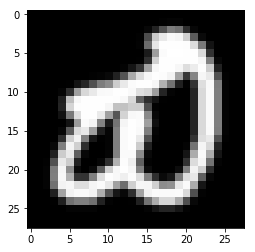

In [21]:
imshow(img[0], cmap='gray')

In [22]:
sample = img.unsqueeze(dim=0).to(DEVICE)
out = model(sample)
_, idx = out.max(dim=-1)
print('예측은 {}'.format(chr(idx.item()+65)))
print('정답은 {}'.format(chr(y+65)))

예측은 B
정답은 B
